# Mitigating gender bias on German Credit Dataset

This notebook explores the topic of bias in Machine Learning using the German Credit Dataset. It explores different metrics used to quantify bias in machine learning, and applies different approaches to mitigating bias in Machine Learning.

### Installations

In [54]:
# !pip install ucimlrepo
# !pip install xgboost

### Imports

In [55]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

## I. Understanding the German Credit Dataset

### Load data

In [56]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

X.head(5)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


### Rename columns for clarity

In [57]:
# variable information 
statlog_german_credit_data.variables

,name,role,type,demographic,description,units,missing_values
0,Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
1,Attribute2,Feature,Integer,None,Duration,months,no
2,Attribute3,Feature,Categorical,None,Credit history,None,no
3,Attribute4,Feature,Categorical,None,Purpose,None,no
4,Attribute5,Feature,Integer,None,Credit amount,None,no
5,Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
6,Attribute7,Feature,Categorical,Other,Present employment since,None,no
7,Attribute8,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


In [58]:
X.columns = ['account_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 
         'savings', 'employment_since', 'installment_rate', 'sex', 'guarantors', 
         'residence_since', 'property', 'age', 'other_plans', 'housing', 
         'num_credits', 'job', 'num_people_maintenance', 'telephone', 'foreign_worker']
X.head()

,account_status,duration,credit_history,purpose,credit_amount,savings,employment_since,installment_rate,sex,guarantors,residence_since,property,age,other_plans,housing,num_credits,job,num_people_maintenance,telephone,foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


### Feature engineering

We transform the categorical features by regrouping and renaming categories for readability.

`account_status` : (qualitative)  - Status of existing checking account 
* A11 :      ... <    0 DM
* A12 : 0 <= ... <  200 DM
* A13 :      ... >= 200 DM / salary assignments for at least 1 year
* A14 : no checking account

In [59]:
# Regroup A12 and A13
X['account_status'] = X['account_status'].replace({
    'A11': 'overdrawn',
    'A12': 'stable balance',
    'A13': 'stable balance',
    'A14': 'no account'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\1278538231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['account_status'] = X['account_status'].replace({


`credit_history` :  (qualitative) 
* A30 : no credits taken/ all credits paid back duly
* A31 : all credits at this bank paid back duly
* A32 : existing credits paid back duly till now
* A33 : delay in paying off in the past
* A34 : critical account/  other credits existing (not at this bank)

In [60]:
# Regroup A30 and A31 into 'good', A33and A34 into 'bad'
X['credit_history'] = X['credit_history'].replace({
    'A30': 'good',
    'A31': 'good',
    'A33': 'bad',
    'A34': 'bad',
    'A32': 'being repaid'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\857528430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['credit_history'] = X['credit_history'].replace({


`purpose` :  (qualitative) 
* A40 : car (new)
* A41 : car (used)
* A42 : furniture/equipment
* A43 : radio/television
* A44 : domestic appliances
* A45 : repairs
* A46 : education
* A47 : (vacation - does not exist?)
* A48 : retraining
* A49 : business
* A410 : others

In [61]:
# Regroup into 6 categories
X['purpose'] = X['purpose'].replace({
    'A40': 'car',
    'A41': 'car',
    'A42': 'domestic equipment',
    'A43': 'domestic equipment',
    'A44': 'domestic equipment',
    'A45': 'others',
    'A46': 'education',
    'A48': 'education',
    'A49': 'business',
    'A410': 'others'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\4091091101.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['purpose'] = X['purpose'].replace({


`savings` :  (qualitative) -  Savings account/bonds
* A61 :          ... <  100 DM
* A62 :   100 <= ... <  500 DM
* A63 :   500 <= ... < 1000 DM
* A64 :          .. >= 1000 DM
* A65 :   unknown/ no savings account

In [62]:
# Regroup into 4 categories
X['savings'] = X['savings'].replace({
    'A61': 'little',
    'A62': 'moderate',
    'A63': 'moderate',
    'A64': 'rich',
    'A65': 'NA'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\176494227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['savings'] = X['savings'].replace({


`employment_since` :  (qualitative) -   Present employment since
* A71 : unemployed
* A72 :       ... < 1 year
* A73 : 1  <= ... < 4 years  
* A74 : 4  <= ... < 7 years
* A75 :       .. >= 7 years

In [63]:
# Regroup into 3 categories
X['employment_since'] = X['employment_since'].replace({
    'A71': 'unemployed',
    'A72': 'recent position',
    'A73': 'recent position',
    'A74': 'long-term position',
    'A75': 'long-term position'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\3040972588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['employment_since'] = X['employment_since'].replace({


`sex` :  (qualitative)  -  Personal status and sex
* A91 : male   : divorced/separated
* A92 : female : divorced/separated/married
* A93 : male   : single
* A94 : male   : married/widowed
* A95 : female : single

In [64]:
# Regroup into 2 categories
X['sex'] = X['sex'].replace({
    'A91': 'male',
    'A93': 'male',
    'A94': 'male',
    'A92': 'female',
    'A95': 'female'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\3959539789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = X['sex'].replace({


`housing` : (qualitative) 
* A151 : rent
* A152 : own
* A153 : for free

In [65]:
# categories didn't change but for better readability
X['housing'] = X['housing'].replace({
    'A151': 'rent',
    'A152': 'own',
    'A153': 'for free'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\3724771477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['housing'] = X['housing'].replace({


`job` : (qualitative) 
* A171 : unemployed/ unskilled  - non-resident
* A172 : unskilled - resident
* A173 : skilled employee / official
* A174 : management/ self-employed/highly qualified employee/ officer

In [66]:
# Regroup into 2 categories
X['job'] = X['job'].replace({
    'A171': 'unskilled',
    'A172': 'unskilled',
    'A173': 'skilled',
    'A174': 'skilled'
})

C:\Users\marie\AppData\Local\Temp\ipykernel_27108\534325810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['job'] = X['job'].replace({


We drop the attributes that we will not use for our predictions.

In [67]:
# Drop specified attributes
X = X.drop(['installment_rate', 'residence_since', 'property', 'other_plans', 'telephone', 'foreign_worker', 'guarantors'], axis=1)
X.head()

,account_status,duration,credit_history,purpose,credit_amount,savings,employment_since,sex,age,housing,num_credits,job,num_people_maintenance
0,overdrawn,6,bad,domestic equipment,1169,NA,long-term position,male,67,own,2,skilled,1
1,stable balance,48,being repaid,domestic equipment,5951,little,recent position,female,22,own,1,skilled,1
2,no account,12,bad,education,2096,little,long-term position,male,49,own,1,unskilled,2
3,overdrawn,42,being repaid,domestic equipment,7882,little,long-term position,male,45,for free,1,skilled,2
4,overdrawn,24,bad,car,4870,little,recent position,male,53,for free,2,skilled,2


We relabel the target variable. We want to identify the good borrowers.

In [68]:
# Map target labels (1 = Good, 2 = Bad) -> (1 = Good, 0 = Bad)
y = y.replace({1: 1, 2: 0})
y.head()

,class
0,1
1,0
2,1
3,1
4,0


### Data visualization

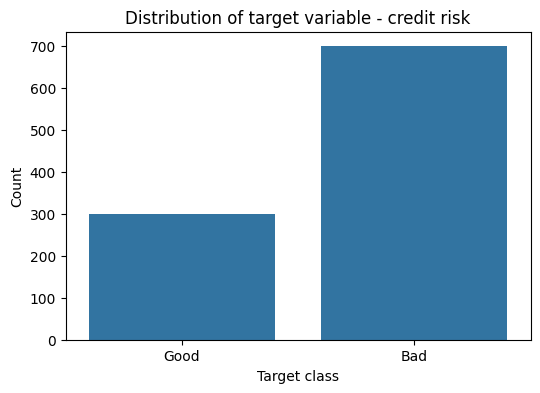

In [69]:
plt.figure(figsize=(6, 4))
sns.countplot(x=pd.Series(np.ravel(y)))
plt.title('Distribution of target variable - credit risk')
plt.xlabel('Target class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=["Good", "Bad"])
plt.show()

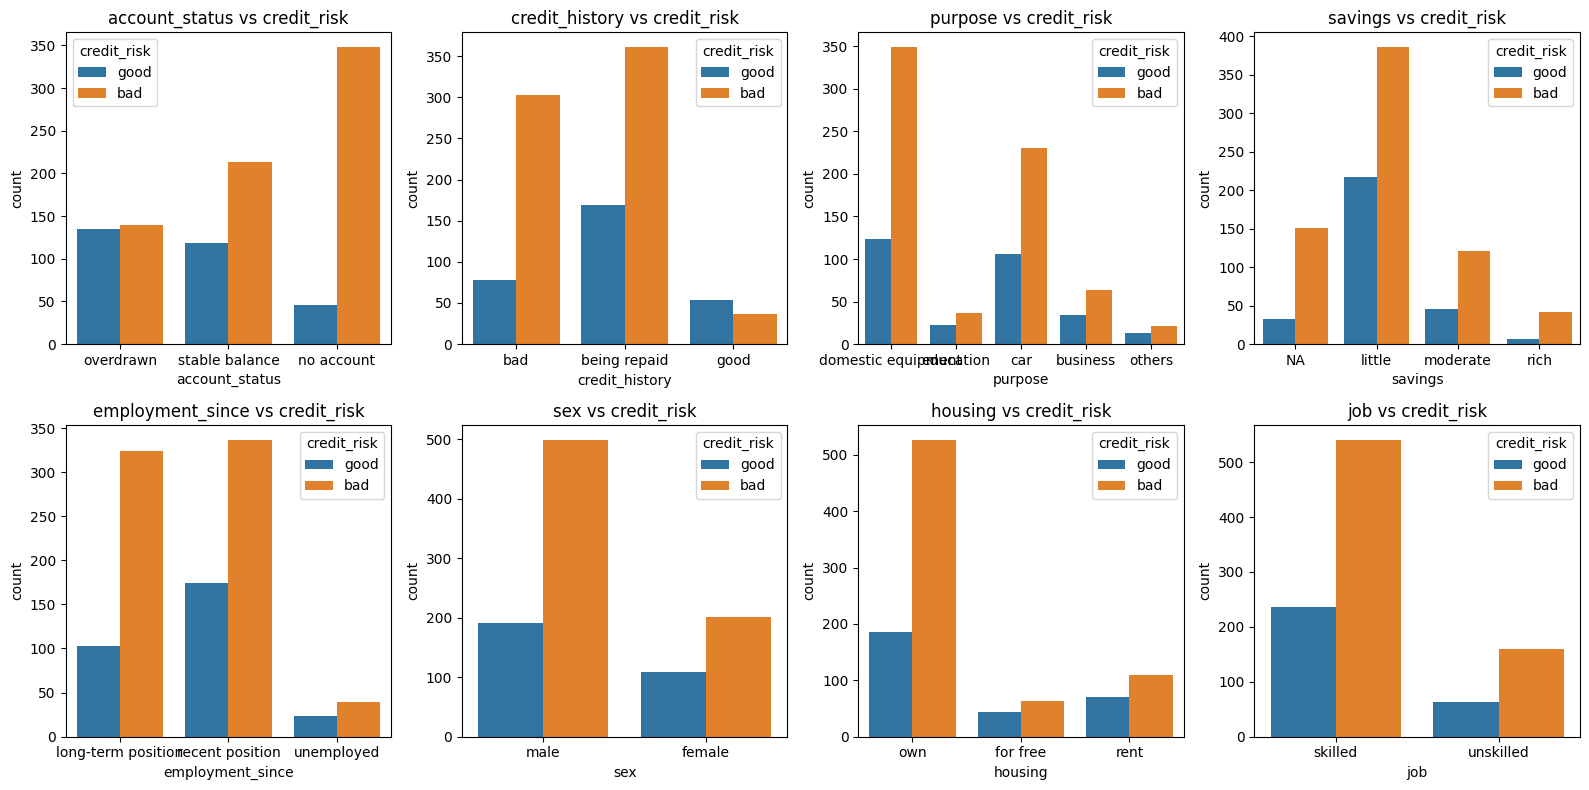

In [70]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()
cat_cols = ['account_status', 'credit_history', 'purpose', 'savings', 'employment_since', 'sex', 'housing','job']
df = pd.concat([X,y], axis=1)
for i, var in enumerate(cat_cols):
    sns.countplot(x=var, data=df, hue='class', ax=axes[i])
    #axes[i].tick_params(axis='x', rotation=90) 
    axes[i].set_title(f'{var} vs credit_risk')
    axes[i].legend(title='credit_risk', labels=['good', 'bad'])
plt.tight_layout()
plt.show()

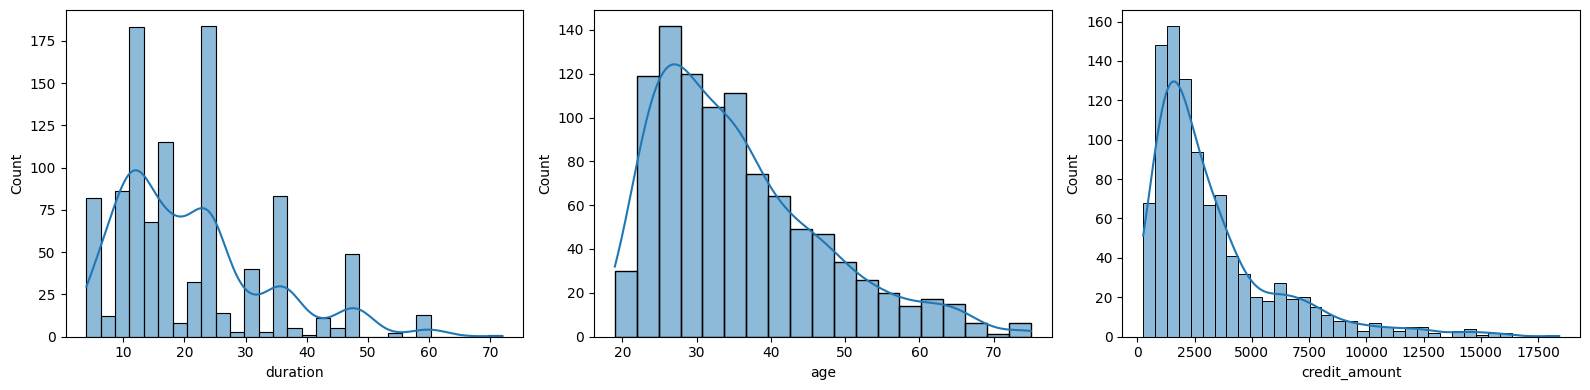

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
axes = axes.flatten()
cont_cols = ['duration', 'age', 'credit_amount']
for i, var in enumerate(cont_cols):
    sns.histplot(x=var, data=X, ax=axes[i], kde=True)
plt.tight_layout()
plt.show()

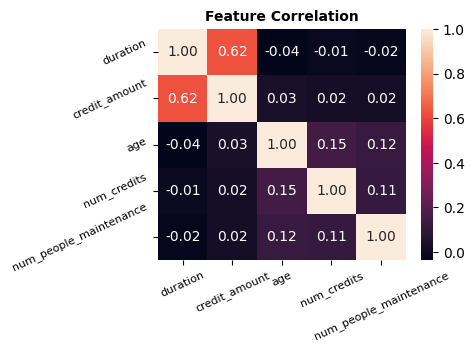

In [72]:
# Select only numeric columns
numeric_df = X.select_dtypes(include=['number'])

# Calculate correlations + plot heatmap
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Feature Correlation', fontsize=10, fontweight='bold')
plt.xticks(fontsize=8, rotation=25)
plt.yticks(fontsize=8, rotation=25)
plt.show()

### Transform continuous variables into categorical

In [73]:
# Duration
category = pd.cut(X['duration'], bins=[0, 12, 24, 36, np.inf], labels=['0-12', '13-24', '25-36', '>36']).astype(str)
X.insert(1, 'duration_cat', category)
# Age
category = pd.cut(X['age'], bins=[0, 25, 30, 35, 40, 50, np.inf], labels=['0-25', '26-30', '31-35', '36-40', '41-50', '>50']).astype(str)
X.insert(9, 'age_group', category)
X = X.drop(['duration', 'age'], axis=1)

We can visualize the distribution of the new categories.

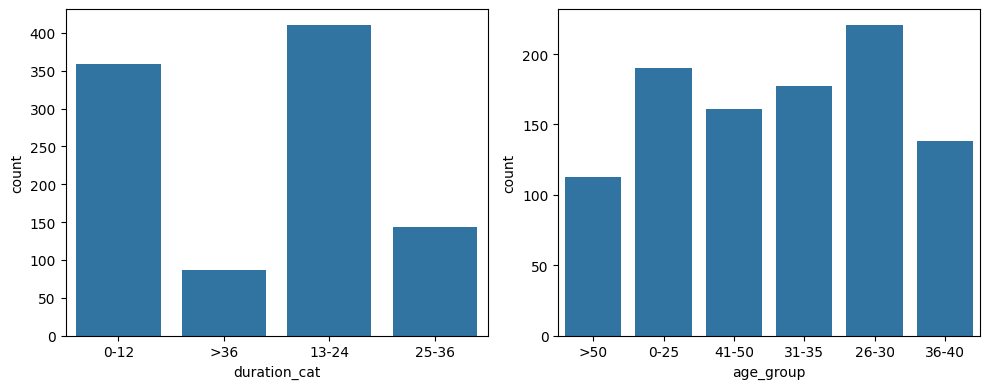

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes = axes.flatten()
cat_cols = ['duration_cat', 'age_group']
for i, var in enumerate(cat_cols):
    sns.countplot(x=var, data=X, ax=axes[i])
plt.tight_layout()
plt.show()

## II. Preparing data for predictions

#### Encode categorical variables

In [75]:
X_encoded = X.copy()

# Ordinal variables 
X_encoded['account_status'] = X_encoded['account_status'].map({'overdrawn': 1, 'no account': 2, 'stable balance': 3})
X_encoded['credit_history'] = X_encoded['credit_history'].map({'bad': 1, 'being repaid': 2, 'good': 3})
X_encoded['savings'] = X_encoded['savings'].map({'NA': 1, 'little':2, 'moderate': 3, 'rich': 4})
X_encoded['employment_since'] = X_encoded['employment_since'].map({'unemployed': 1, 'recent position': 2, 'long-term position': 3})
X_encoded['job'] = X_encoded['job'].map({'unskilled': 1, 'skilled': 2})
X_encoded['duration_cat'] = X_encoded['duration_cat'].map({'0-12': 1, '13-24': 2, '25-36': 3, '>36': 4}).astype(int)
X_encoded['age_group'] = X_encoded['age_group'].map({'0-25': 1, '26-30': 2, '31-35': 3, '36-40': 4, '41-50': 5, '>50': 6}).astype(int)

# Binary Encoding for the Sex variable
label=LabelEncoder()
X_encoded['sex']=label.fit_transform(X_encoded['sex'])

# One-Hot Encoding for non-ordinal variables
X_encoded = pd.get_dummies(X_encoded, columns=['purpose', 'housing'], drop_first=True)

#### Split the dataset

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=123)

#### Scaling

In [77]:
scaler=MinMaxScaler()
X_train['credit_amount']=scaler.fit_transform(X_train[['credit_amount']])
X_test['credit_amount']=scaler.fit_transform(X_test[['credit_amount']])

## III. Modeling without debiasing

### III.1. Baseline models

#### Decision Tree

In [78]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train.values.ravel())
dt_pred = dt.predict(X_test)

#### Logistic Regression

In [79]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train.values.ravel())
lr_pred = lr.predict(X_test)

#### Random Forest

In [80]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())
rf_pred = rf.predict(X_test)

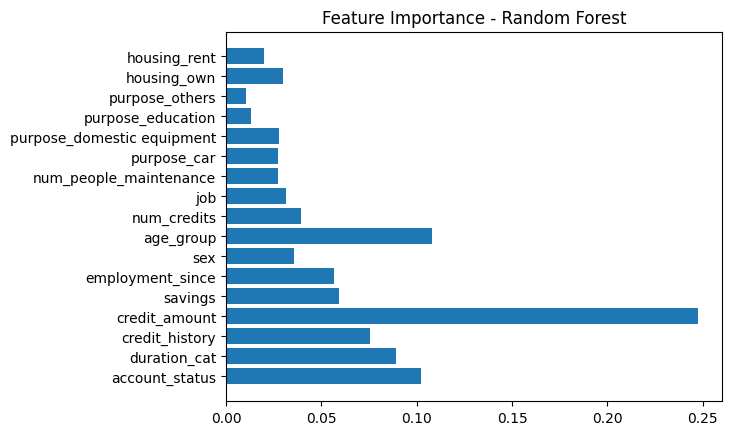

In [81]:
# Get feature importances
feature_importances = rf.feature_importances_
# Plot feature importance
plt.barh(X_train.columns, feature_importances)
plt.title("Feature Importance - Random Forest")
plt.show()

#### XGBoost

In [82]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train.values.ravel())
xgb_pred = xgb.predict(X_test)

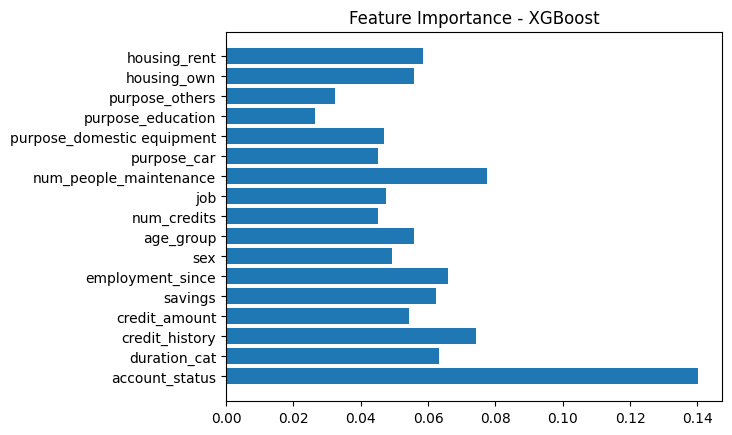

In [83]:
# Get feature importances
feature_importances = xgb.feature_importances_

# Plot feature importance
plt.barh(X_train.columns, feature_importances)
plt.title("Feature Importance - XGBoost")
plt.show()

### III.2. Model performance

In [84]:
def get_model_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    # cost matrix (rows = true classes, columns = predicted classes)
    cost_matrix = np.array([[0, 5],  # Cost for Bad (0)
                            [1, 0]]) # Cost for Good (1)
    cost = np.sum(conf_matrix * cost_matrix)
    print("Accuracy:", accuracy)
    print("Balanced accuracy:", balanced_acc)
    print("Confusion Matrix:\n", conf_matrix)
    print("Total Cost of Misclassification:", cost)

In [85]:
for clf in [rf, lr, dt, xgb]:
    y_pred = clf.predict(X_test)
    print(f'==== {clf.__class__.__name__} ====\n')
    get_model_performance(y_test, y_pred)
    print('\n')

==== RandomForestClassifier ====

Accuracy: 0.765
Balanced accuracy: 0.6975468805283642
Confusion Matrix:
 [[ 32  29]
 [ 18 121]]
Total Cost of Misclassification: 163


==== LogisticRegression ====

Accuracy: 0.7
Balanced accuracy: 0.5817903054605496
Confusion Matrix:
 [[ 17  44]
 [ 16 123]]
Total Cost of Misclassification: 236


==== DecisionTreeClassifier ====

Accuracy: 0.71
Balanced accuracy: 0.6763769312418917
Confusion Matrix:
 [[ 36  25]
 [ 33 106]]
Total Cost of Misclassification: 158


==== XGBClassifier ====

Accuracy: 0.795
Balanced accuracy: 0.7421276093878995
Confusion Matrix:
 [[ 37  24]
 [ 17 122]]
Total Cost of Misclassification: 137




In [86]:
def plot_roc_curve(clfs, X_test, y_true):
    plt.figure(figsize=(8, 6))
    for clf in clfs:
        probs = clf.predict_proba(X_test)
        preds = probs[:, 1]
        fpr, tpr, _ = roc_curve(y_true, preds)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label= f'{clf.__class__.__name__} (auc = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.xlim(0, 1)
    plt.ylim(0,1)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC curve', fontsize=16, fontweight="bold")
    plt.legend(fontsize=12)
    plt.show()

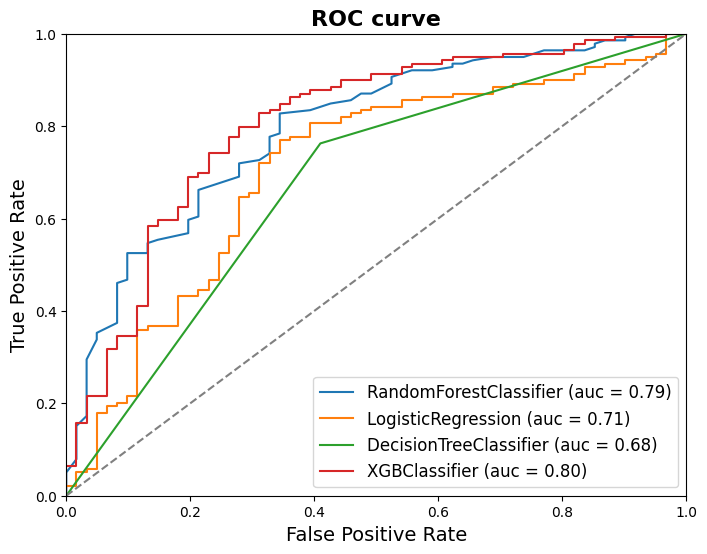

In [87]:
plot_roc_curve([rf, lr, dt, xgb], X_test, y_test)

### III.3. Fairness metrics

In [88]:
def classification_metrics(y_true, y_pred):
    """
    Compute classification metrics based on the confusion matrix.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.

    Returns:
        tuple: ACC (Accuracy), TPR (True Positive Rate), FPR (False Positive Rate),
            FNR (False Negative Rate), PPP (Predicted as Positive Proportion)
    """
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    N = TP + FP + FN + TN # Total population
    ACC = (TP + TN) / N # Accuracy
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 # True positive rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0 # False positive rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0 # False negative rate
    PPP = (TP + FP) / N if N > 0 else 0 # Predicted as positive
    
    return ACC, TPR, FPR, FNR, PPP

In [89]:
def classification_metrics_per_group(y_true, y_pred, X_test, sens_att):
    """
    Compute classification metrics for each group defined by a sensitive attribute.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: A dictionary where each key is a group value and the value is a dictionary
            of classification metrics (ACC, TPR, FPR, FNR, PPP) for that group.
    """
    groups = X_test[sens_att]
    metrics = {}
    for group in np.unique(groups):
        group_mask = (groups == group)
        ACC, TPR, FPR, FNR, PPP = classification_metrics(y_true[group_mask], y_pred[group_mask])
        metrics[group] = {
            'ACC': ACC,
            'TPR': TPR,
            'FPR': FPR,
            'FNR': FNR,
            'PPP': PPP,
        }
    return metrics

In [90]:
def compute_fairness_metrics(y_true, y_pred, X_test, sens_att):
    """
    Compute fairness metrics for a model based on a sensitive attribute.

    Args:
        y_true (1d array-like): True labels.
        y_pred (1d array-like): Predicted labels.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_att (str): Name of the sensitive attribute column.

    Returns:
        dict: Fairness metrics including demographic parity difference, 
            equal opportunity difference, and average odds difference.
    """
    group_metrics = classification_metrics_per_group(y_true, y_pred, X_test, sens_att)
    group_0, group_1 = group_metrics[0], group_metrics[1]
    fair_metrics = {}
    fair_metrics['Demographic parity difference'] = group_0['PPP'] - group_1['PPP']
    fair_metrics['Equal opportunity difference'] = group_0['TPR'] - group_1['TPR']
    fair_metrics['Average odds difference'] = np.mean([group_0['TPR'] - group_1['TPR'], group_1['FPR'] - group_1['FPR']])
    return fair_metrics

In [91]:
for clf in [rf, lr, dt, xgb]:
    y_pred = clf.predict(X_test)
    print(f'==== {clf.__class__.__name__} ====\n')
    fair_metrics = compute_fairness_metrics(y_test, y_pred, X_test, 'sex')
    for key, value in fair_metrics.items():
        print(f"{key}: {value}")
    print('\n')

==== RandomForestClassifier ====

Demographic parity difference: -0.13952308472856423
Equal opportunity difference: -0.1011204481792718
Average odds difference: -0.0505602240896359


==== LogisticRegression ====

Demographic parity difference: -0.12912227295788947
Equal opportunity difference: -0.08123249299719892
Average odds difference: -0.04061624649859946


==== DecisionTreeClassifier ====

Demographic parity difference: -0.13622526636225263
Equal opportunity difference: -0.11400560224089629
Average odds difference: -0.05700280112044814


==== XGBClassifier ====

Demographic parity difference: -0.18822932521562663
Equal opportunity difference: -0.07170868347338943
Average odds difference: -0.03585434173669472




## IV. Mitigating bias

In this section, we will be exploring the following bias mitigation techniques :
* Reweighting (Kamiran and Calders (2012))
* Reject Option base Classification (Kamiran et al. (2012))

### IV.1. Reweighting (Kamiran and Calders (2012))

Reweighting is a bias mitigation technique introduced by Kamiran and Calders (2012) that adjusts the importance of data instances based on the sensitive attribute $(S)$ and class label $(C)$. The weights for each combination of $S$ and $C$ are computed as :
$$w(s,c) = \frac{P_{exp}(S=s, C=c)}{P_{obs}(S=s, C=c)} = \frac{P(S=s)\cdot P(C=c)}{P(S=s, C=c)}$$
Here, $P_{obs}$ is the observed joint probability, and $P_{exp}$ assumes independance between $S$ and $C$. 

In [92]:
def reweighing(X, y, sensitive_attr):
    """
    Reweighting function to calculate instance weights based on the sensitive attribute and class labels.

    Args:
        X (pd.DataFrame): Feature DataFrame, must include the sensitive attribute column.
        y (pd.DataFrame): Labels corresponding to X.
        sensitive_attr (str): The name of the sensitive attribute column in X.

    Returns:
        pd.Series: Instance weights for each row in the dataset
    """
    # Combine X and y into a single DataFrame for easier grouping
    data = X.copy()
    data['class'] = y

    # Calculate marginal probabilities P(S=s) and P(C=c)
    p_sensitive = data[sensitive_attr].value_counts(normalize=True).to_dict()
    p_class = data['class'].value_counts(normalize=True).to_dict()

    # Calculate joint probabilities P(S=s, C=c)
    joint_counts = data.groupby([sensitive_attr, 'class']).size()
    p_joint = (joint_counts / len(data)).to_dict()

    # Calculate weights for each (S, C) pair
    weights_dict = {}
    for (s, c), p_obs in p_joint.items():
        p_exp = p_sensitive[s] * p_class[c]
        weights_dict[(s, c)] = p_exp / p_obs

    # Assign weights to each instance
    weights = data.apply(lambda row: weights_dict[(row[sensitive_attr], row['class'])], axis=1)
    
    return weights, weights_dict

In [93]:
weights, weights_dict = reweighing(X_train, y_train, 'sex')

In [94]:
weights_dict

{(0, 0): 0.8593258426966293,
 (0, 1): 1.0749700598802396,
 (1, 0): 1.0834666666666668,
 (1, 1): 0.9682233502538072}

#### Random Forest

In [95]:
rf_weight = RandomForestClassifier(random_state=42)
rf_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
rf_weight_pred = rf_weight.predict(X_test)

In [96]:
print('========= Random Forest =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, rf_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, rf_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, rf_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, rf_weight_pred)

========= Random Forest =========

Fairness metrics - baseline:
{'Demographic parity difference': np.float64(-0.13952308472856423), 'Equal opportunity difference': np.float64(-0.1011204481792718), 'Average odds difference': np.float64(-0.0505602240896359)}


Fairness metrics - reweighted:
{'Demographic parity difference': np.float64(-0.10730593607305938), 'Equal opportunity difference': np.float64(-0.09159663865546219), 'Average odds difference': np.float64(-0.045798319327731096)}


Model performance - baseline:
Accuracy: 0.765
Balanced accuracy: 0.6975468805283642
Confusion Matrix:
 [[ 32  29]
 [ 18 121]]
Total Cost of Misclassification: 163


Model performance - reweighted:
Accuracy: 0.76
Balanced accuracy: 0.693949758226206
Confusion Matrix:
 [[ 32  29]
 [ 19 120]]
Total Cost of Misclassification: 164


#### XGBoost

In [97]:
xgb_weight = XGBClassifier(random_state=42)
xgb_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
xgb_weight_pred = xgb_weight.predict(X_test)

In [98]:
print('========= XGBoost =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, xgb_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, xgb_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, xgb_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, xgb_weight_pred)

========= XGBoost =========

Fairness metrics - baseline:
{'Demographic parity difference': np.float64(-0.18822932521562663), 'Equal opportunity difference': np.float64(-0.07170868347338943), 'Average odds difference': np.float64(-0.03585434173669472)}


Fairness metrics - reweighted:
{'Demographic parity difference': np.float64(-0.20674784373414512), 'Equal opportunity difference': np.float64(-0.0820728291316527), 'Average odds difference': np.float64(-0.04103641456582635)}


Model performance - baseline:
Accuracy: 0.795
Balanced accuracy: 0.7421276093878995
Confusion Matrix:
 [[ 37  24]
 [ 17 122]]
Total Cost of Misclassification: 137


Model performance - reweighted:
Accuracy: 0.77
Balanced accuracy: 0.7149427998584739
Confusion Matrix:
 [[ 35  26]
 [ 20 119]]
Total Cost of Misclassification: 150


#### Logistic Regression

In [99]:
lr_weight = LogisticRegression(random_state=42)
lr_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
lr_weight_pred = lr_weight.predict(X_test)

In [100]:
print('========= Logistic Regression =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, lr_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, lr_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, lr_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, lr_weight_pred)

========= Logistic Regression =========

Fairness metrics - baseline:
{'Demographic parity difference': np.float64(-0.12912227295788947), 'Equal opportunity difference': np.float64(-0.08123249299719892), 'Average odds difference': np.float64(-0.04061624649859946)}


Fairness metrics - reweighted:
{'Demographic parity difference': np.float64(0.004566210045662156), 'Equal opportunity difference': np.float64(0.006162464985994376), 'Average odds difference': np.float64(0.003081232492997188)}


Model performance - baseline:
Accuracy: 0.7
Balanced accuracy: 0.5817903054605496
Confusion Matrix:
 [[ 17  44]
 [ 16 123]]
Total Cost of Misclassification: 236


Model performance - reweighted:
Accuracy: 0.695
Balanced accuracy: 0.5781931831583913
Confusion Matrix:
 [[ 17  44]
 [ 17 122]]
Total Cost of Misclassification: 237


#### Decision Tree

In [101]:
dt_weight = DecisionTreeClassifier(random_state=42)
dt_weight.fit(X_train, y_train.values.ravel(), sample_weight=weights)
dt_weight_pred = dt_weight.predict(X_test)

In [102]:
print('========= Decision Tree =========\n')
print("Fairness metrics - baseline:")
print(compute_fairness_metrics(y_test, dt_pred, X_test, 'sex'))
print('\n')
print("Fairness metrics - reweighted:")
print(compute_fairness_metrics(y_test, dt_weight_pred, X_test, 'sex'))
print('\n')
print("Model performance - baseline:")
get_model_performance(y_test, dt_pred)
print('\n')
print("Model performance - reweighted:")
get_model_performance(y_test, dt_weight_pred)

========= Decision Tree =========

Fairness metrics - baseline:
{'Demographic parity difference': np.float64(-0.13622526636225263), 'Equal opportunity difference': np.float64(-0.11400560224089629), 'Average odds difference': np.float64(-0.05700280112044814)}


Fairness metrics - reweighted:
{'Demographic parity difference': np.float64(-0.0025367833587012223), 'Equal opportunity difference': np.float64(-0.1044817927170868), 'Average odds difference': np.float64(-0.0522408963585434)}


Model performance - baseline:
Accuracy: 0.71
Balanced accuracy: 0.6763769312418917
Confusion Matrix:
 [[ 36  25]
 [ 33 106]]
Total Cost of Misclassification: 158


Model performance - reweighted:
Accuracy: 0.705
Balanced accuracy: 0.6727798089397334
Confusion Matrix:
 [[ 36  25]
 [ 34 105]]
Total Cost of Misclassification: 159


### IV.2. Reject Option based Classification (Kamiran et al. (2012))

Reject option based classification is a postprocessing technique designed by Kamiran et al. (2012) to mitigate discrimination in binary classification tasks. This approach deviates from traditional classification rules by incorporating a reject option for instances with uncertain classifications. The method introduces the concept of a critical region where the classification decision is uncertain. Instances falling within this region are relabeled to reduce discrimination : the method assigns favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups.

In [103]:
def reject_option_classification(clf, X_test, sens_att, theta):
    """
    Apply Reject Option-based Classification (ROC)
    
    Args:
        clf (object): A trained classifier with a predict method.
        X_test (pd.DataFrame): Test features containing the sensitive attribute.
        sens_attr (str): The name of the sensitive attribute column in X
        theta (float): Threshold for the critical region.
    
    Returns:
        np.array: Predictions after applying ROC.
    """
    y_pred = clf.predict(X_test) # Original predictions (e.g., thresholded at 0.5).
    probs = clf.predict_proba(X_test)[:,1] # Predicted probabilities for the positive class.
    roc_pred = np.copy(y_pred)
    for i, p in enumerate(probs):
        # In critical region, reassign label based on group
        if max(p, 1 - p) <= theta:
            if X_test[sens_att].reset_index(drop=True)[i] == 0:  # Unprivileged group (e.g., female)
                roc_pred[i] = 1  # Favorable outcome (e.g. good credit)
            else:  # Privileged group
                roc_pred[i] = 0  # Unfavorable outcome (e.g. bad credit)
    return roc_pred

In [104]:
def find_best_thresholds(clf, y_true, X_test, sens_att, metric_names):
    """
    Find the best threshold for Reject Option Classification for multiple fairness metrics.
    
    Parameters:
        clf: Trained classifier with `predict_proba`.
        y_true (np.array): True labels.
        X_test (np.array): Test features.
        sens_att (np.array): Sensitive attributes for the test set.
        metric_names (list): List of fairness metric names to evaluate.
        
    Returns:
        dict, list: Best thresholds for each metric and List of metrics at each threshold.
    """
    best_thetas = {metric: None for metric in metric_names}
    best_scores = {metric: -np.inf for metric in metric_names}
    metrics_list = []  # Store metrics for all thresholds
    
    for theta in np.arange(0.5, 1, 0.01):
        roc_pred = reject_option_classification(clf, X_test, sens_att, theta)
        accuracy = accuracy_score(y_true, roc_pred)
        fairness_metrics = compute_fairness_metrics(y_true, roc_pred, X_test, sens_att)
        
        # Store all metrics for this threshold
        threshold_metrics = {"theta": theta, "accuracy": accuracy}
        for metric_name in metric_names:
            threshold_metrics[metric_name] = fairness_metrics[metric_name]
            # Combine accuracy and fairness into a single score (e.g., weighted sum)
            score = accuracy - abs(fairness_metrics[metric_name])
            if score > best_scores[metric_name]:
                best_scores[metric_name] = score
                best_thetas[metric_name] = theta    
        metrics_list.append(threshold_metrics)
    
    return best_thetas, metrics_list

In [105]:
def plot_metrics_vs_thresholds(metrics_list, metric_names, best_thetas, clf_name):
    """
    Plot accuracy and multiple fairness metrics across thresholds.
    
    Args:
        metrics_list (list): List of metrics at each threshold.
        metric_names (list): List of fairness metrics to plot.
        best_thetas (dict): Best threshold for each metric.
        clf_name (str): Name of the classifier.
    """
    thresholds = [m["theta"] for m in metrics_list]
    accuracies = [m["accuracy"] for m in metrics_list]
    
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, accuracies, label="Accuracy", color="blue")
    
    # Plot each fairness metric
    colors = ["orange", "green", "red"] 
    for i, metric_name in enumerate(metric_names):
        fairness_metrics = [m[metric_name] for m in metrics_list]
        plt.plot(thresholds, fairness_metrics, label=metric_name, color=colors[i % len(colors)])
        best_theta = best_thetas[metric_name]
        plt.axvline(x=best_theta, color=colors[i % len(colors)], linestyle=":", label=f"Best threshold: θ={best_theta:.2f}")
    plt.axhline(y=0, color="grey", linestyle="--", label="Optimal fairness")
    plt.xlabel("Classification threshold (theta)")
    plt.ylabel("Accuracy and Fairness metrics")
    plt.title(f"{clf_name}", fontsize=16, fontweight="bold")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

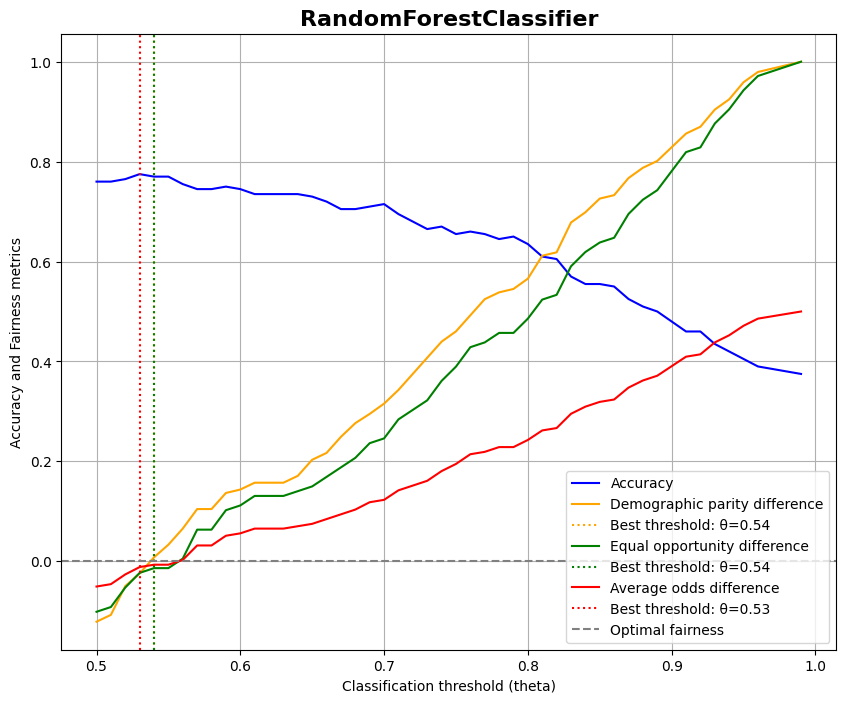

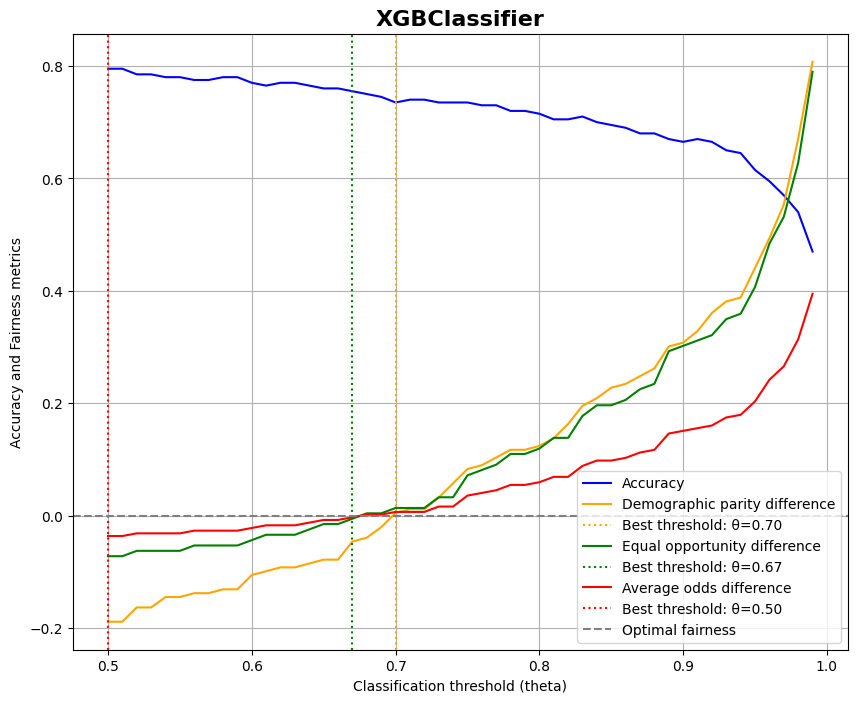

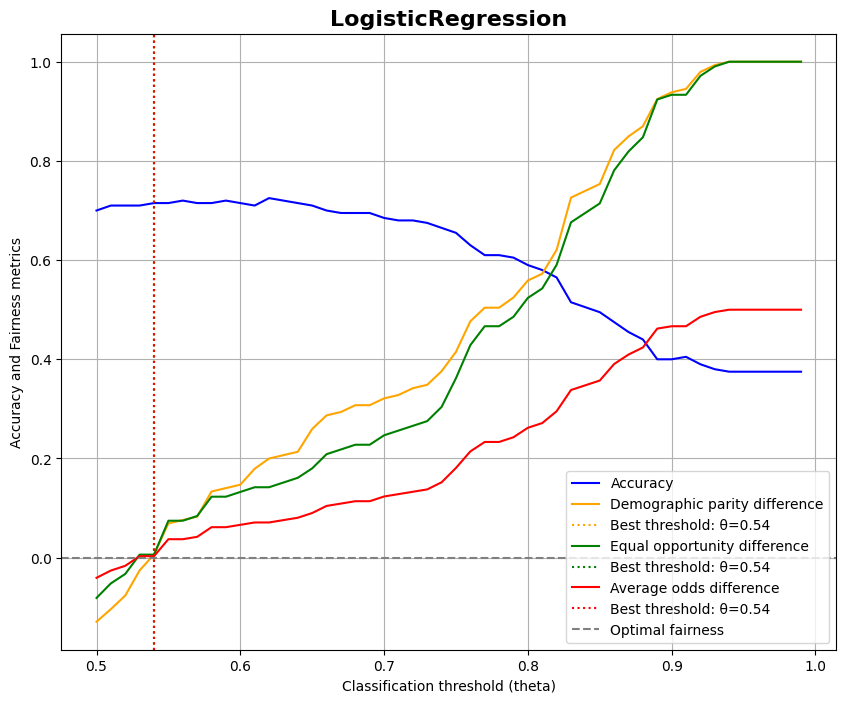

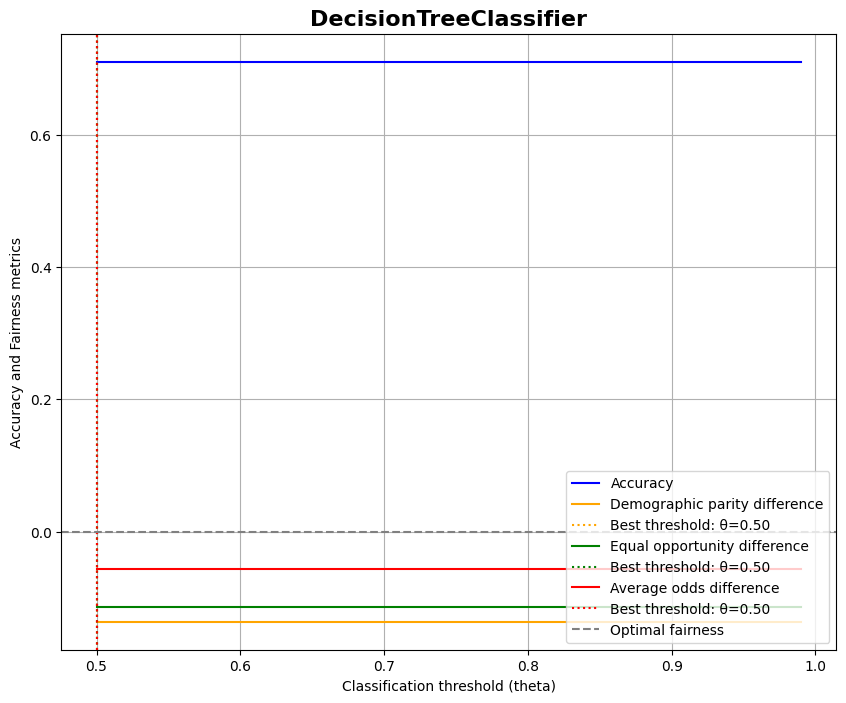

In [106]:
metric_names = [
    "Demographic parity difference",
    "Equal opportunity difference",
    "Average odds difference",
]
clfs = [rf, xgb, lr, dt]
for clf in clfs:
    best_thetas, metrics_list = find_best_thresholds(clf, y_test, X_test, 'sex', metric_names)
    plot_metrics_vs_thresholds(metrics_list, metric_names, best_thetas, clf.__class__.__name__)

In [107]:
for clf in [rf, xgb, lr]:
    best_thetas, _ = find_best_thresholds(clf, y_test, X_test, 'sex', metric_names)
    print(f'======== {clf.__class__.__name__} ========\n')
    for metric_name, theta in best_thetas.items():
        print(f"Optimizing {metric_name} :")
        print(f"Classification threshold : {theta}")
        roc_pred = reject_option_classification(clf, X_test, 'sex', theta)
        print("Accuracy:", accuracy_score(y_test, roc_pred))
        print("Balanced accuracy:", balanced_accuracy_score(y_test, roc_pred))
        fair_metrics = compute_fairness_metrics(y_test, roc_pred, X_test, 'sex')
        for k, v in fair_metrics.items():
            print(f"{k}: {v}")
        print('\n')

======== RandomForestClassifier ========

Optimizing Demographic parity difference :
Classification threshold : 0.54
Accuracy: 0.77
Balanced accuracy: 0.7103432008491567
Demographic parity difference: 0.007864028411973534
Equal opportunity difference: -0.013725490196078494
Average odds difference: -0.006862745098039247


Optimizing Equal opportunity difference :
Classification threshold : 0.54
Accuracy: 0.77
Balanced accuracy: 0.7103432008491567
Demographic parity difference: 0.007864028411973534
Equal opportunity difference: -0.013725490196078494
Average odds difference: -0.006862745098039247


Optimizing Average odds difference :
Classification threshold : 0.53
Accuracy: 0.775
Balanced accuracy: 0.7139403231513151
Demographic parity difference: -0.0243531202435312
Equal opportunity difference: -0.023249299719887984
Average odds difference: -0.011624649859943992


======== XGBClassifier ========

Optimizing Demographic parity difference :
Classification threshold : 0.7000000000000002
